# 1. Dependencias
---

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.seasonal import seasonal_decompose
from utilsforecast.plotting import plot_series
from utilsforecast.evaluation import evaluate
from utilsforecast.losses import *


# 2. Carga de datos 
---

In [45]:
df_admission = pd.read_csv("./data/HDHI_admission_data.csv")
df_weather = pd.read_csv("./data/HDHI_pollution_data.csv")

In [46]:
# Limpiamos y renombramos las columnas originales del df
df_admission.columns = df_admission.columns.str.strip()

mapping = {
    'SNO': 'serial_number',
    'MRD No.': 'mrd_number',
    'D.O.A': 'admission_date',
    'D.O.D': 'discharge_date',
    'AGE': 'age',
    'GENDER': 'gender',
    'RURAL': 'residence_rural',
    'TYPE OF ADMISSION-EMERGENCY/OPD': 'admission_type',
    'month year': 'admission_month_year',
    'DURATION OF STAY': 'length_of_stay_days',
    'duration of intensive unit stay': 'icu_length_of_stay_days',
    'OUTCOME': 'hospital_outcome',
    'SMOKING': 'smoking_status',
    'ALCOHOL': 'alcohol_use',
    'DM': 'diabetes',
    'HTN': 'hypertension',
    'CAD': 'coronary_artery_disease',
    'PRIOR CMP': 'prior_cva',                     # CMP -> cerebrovascular accident (ajusta si tu significado es otro)
    'CKD': 'chronic_kidney_disease',
    'HB': 'hemoglobin_g_dl',
    'TLC': 'total_leukocyte_count',
    'PLATELETS': 'platelet_count',
    'GLUCOSE': 'glucose_mg_dl',
    'UREA': 'urea_mg_dl',
    'CREATININE': 'creatinine_mg_dl',
    'BNP': 'bnp',
    'RAISED CARDIAC ENZYMES': 'raised_cardiac_enzymes',
    'EF': 'ejection_fraction_percent',
    'SEVERE ANAEMIA': 'severe_anemia',
    'ANAEMIA': 'anemia',
    'STABLE ANGINA': 'stable_angina',
    'ACS': 'acute_coronary_syndrome',
    'STEMI': 'stemi',
    'ATYPICAL CHEST PAIN': 'atypical_chest_pain',
    'HEART FAILURE': 'heart_failure',
    'HFREF': 'hf_ref',                             # HFrEF (reduced EF)
    'HFNEF': 'hf_nef',                             # HFpEF/HFNEF (preserv. EF) — cambia si prefieres hf_pef
    'VALVULAR': 'valvular_disease',
    'CHB': 'complete_heart_block',
    'SSS': 'sick_sinus_syndrome',
    'AKI': 'acute_kidney_injury',
    'CVA INFRACT': 'cva_infarct',
    'CVA BLEED': 'cva_bleed',
    'AF': 'atrial_fibrillation',
    'VT': 'ventricular_tachycardia',
    'PSVT': 'psvt',
    'CONGENITAL': 'congenital_heart_disease',
    'UTI': 'urinary_tract_infection',
    'NEURO CARDIOGENIC SYNCOPE': 'neurocardiogenic_syncope',
    'ORTHOSTATIC': 'orthostatic_hypotension',
    'INFECTIVE ENDOCARDITIS': 'infective_endocarditis',
    'DVT': 'deep_vein_thrombosis',
    'CARDIOGENIC SHOCK': 'cardiogenic_shock',
    'SHOCK': 'shock',
    'PULMONARY EMBOLISM': 'pulmonary_embolism',
    'CHEST INFECTION': 'chest_infection'
}

df_admission.rename(columns=mapping, inplace=True)

In [47]:
# Estructura del dataset
df_admission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15757 entries, 0 to 15756
Data columns (total 56 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   serial_number              15757 non-null  int64 
 1   mrd_number                 15757 non-null  object
 2   admission_date             15757 non-null  object
 3   discharge_date             15757 non-null  object
 4   age                        15757 non-null  int64 
 5   gender                     15757 non-null  object
 6   residence_rural            15757 non-null  object
 7   admission_type             15757 non-null  object
 8   admission_month_year       15757 non-null  object
 9   length_of_stay_days        15757 non-null  int64 
 10  icu_length_of_stay_days    15757 non-null  int64 
 11  hospital_outcome           15757 non-null  object
 12  smoking_status             15757 non-null  int64 
 13  alcohol_use                15757 non-null  int64 
 14  diabet

In [48]:
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 737 entries, 0 to 736
Data columns (total 27 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   DATE                 737 non-null    object 
 1   AQI                  737 non-null    int64  
 2   PM2.5 AVG            737 non-null    int64  
 3   PM2.5 MIN            737 non-null    int64  
 4   PM2.5 MAX            737 non-null    int64  
 5   PM10 AVG             737 non-null    int64  
 6   PM10 MIN             737 non-null    int64  
 7   PM10 MAX             737 non-null    object 
 8   NO2 AVG              737 non-null    int64  
 9   NO2 MIN              737 non-null    int64  
 10  NO2 MAX              737 non-null    object 
 11  NH3 AVG              737 non-null    int64  
 12  NH3 MIN              737 non-null    int64  
 13  NH3 MAX              737 non-null    int64  
 14  SO2 AVG              737 non-null    int64  
 15  SO2 MIN              737 non-null    int

In [49]:
# Convertimos las fechas de admisión a tipo datetime
df_admission['admission_date'] = pd.to_datetime(
    df_admission['admission_date'],
    dayfirst=False,     # True si el formato es día/mes/año
    errors='coerce'     # convierte formatos inválidos a NaT en lugar de fallar
)

# Convertimos las fechas de alta y de alta a tipo datetime
df_admission["discharge_date"] = pd.to_datetime(
    df_admission['discharge_date'], 
    dayfirst=False,     # True si el formato es día/mes/año
    errors='coerce'     # convierte formatos inválidos a NaT en lugar de fallar
)

df_weather['DATE'] = pd.to_datetime(
  df_weather['DATE'], 
  dayfirst=False, 
  errors='coerce'
)

df_admission.head(100)

,serial_number,mrd_number,admission_date,discharge_date,age,gender,residence_rural,admission_type,admission_month_year,length_of_stay_days,...,congenital_heart_disease,urinary_tract_infection,neurocardiogenic_syncope,orthostatic_hypotension,infective_endocarditis,deep_vein_thrombosis,cardiogenic_shock,shock,pulmonary_embolism,chest_infection
0,1,234735,2017-04-01,2017-04-03,81,M,R,E,Apr-17,3,...,0,0,0,0,0,0,0,0,0,0
1,2,234696,2017-04-01,2017-04-05,65,M,R,E,Apr-17,5,...,0,0,0,0,0,0,0,0,0,0
2,3,234882,2017-04-01,2017-04-03,53,M,U,E,Apr-17,3,...,0,0,0,0,0,0,0,0,0,0
3,4,234635,2017-04-01,2017-04-08,67,F,U,E,Apr-17,8,...,0,0,0,0,0,0,0,0,0,0
4,5,234486,2017-04-01,2017-04-23,60,F,U,E,Apr-17,23,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,96,48098,2017-04-05,2017-04-10,65,F,R,O,Apr-17,6,...,0,0,0,0,0,0,1,1,0,0
96,97,240740,2017-04-05,2017-04-08,45,M,U,O,Apr-17,4,...,0,0,0,0,0,0,0,0,0,0
97,98,253157,2017-05-04,2017-11-04,43,M,U,E,Apr-17,7,...,0,0,0,0,0,0,0,0,0,0
98,99,382348,2017-04-05,2017-04-07,47,M,U,E,Apr-17,3,...,0,0,0,0,0,0,0,0,0,0


In [50]:
df_weather.head(5)

,DATE,AQI,PM2.5 AVG,PM2.5 MIN,PM2.5 MAX,PM10 AVG,PM10 MIN,PM10 MAX,NO2 AVG,NO2 MIN,...,CO AVG,CO MIN,CO MAX,OZONE AVG,OZONE MIN,OZONE MAX,PROMINENT POLLUTENT,MAX TEMP,MIN TEMP,HUMIDITY
0,2017-03-25,75,75,45,210,74,50,110,28,40,...,34,1,49,38,21,70,PM2.5,36,18,32.0
1,2017-03-26,82,82,47,153,75,65,86,29,26,...,32,7,55,30,8,70,PM2.5,38,19,23.0
2,2017-03-27,72,72,63,150,71,45,98,38,34,...,40,10,68,26,18,53,PM2.5,40,20,14.0
3,2017-03-28,80,78,63,88,80,73,87,39,37,...,25,12,48,21,4,71,PM10,40,21,36.0
4,2017-03-29,73,64,53,75,73,63,86,38,36,...,35,20,54,32,6,56,PM10,40,23,31.0


In [51]:
# Mostramos los valores nulos
df_admission.isna().sum().sort_values(ascending=False)

bnp                          8441
admission_date               5655
discharge_date               5550
ejection_fraction_percent    1505
glucose_mg_dl                 863
total_leukocyte_count         286
platelet_count                285
hemoglobin_g_dl               252
creatinine_mg_dl              247
urea_mg_dl                    241
acute_kidney_injury             0
sick_sinus_syndrome             0
complete_heart_block            0
valvular_disease                0
hf_nef                          0
hf_ref                          0
serial_number                   0
cva_bleed                       0
cva_infarct                     0
atypical_chest_pain             0
atrial_fibrillation             0
ventricular_tachycardia         0
psvt                            0
congenital_heart_disease        0
urinary_tract_infection         0
neurocardiogenic_syncope        0
orthostatic_hypotension         0
infective_endocarditis          0
deep_vein_thrombosis            0
cardiogenic_sh

In [52]:
df_admission[df_admission['admission_date'].isna()].head()

,serial_number,mrd_number,admission_date,discharge_date,age,gender,residence_rural,admission_type,admission_month_year,length_of_stay_days,...,congenital_heart_disease,urinary_tract_infection,neurocardiogenic_syncope,orthostatic_hypotension,infective_endocarditis,deep_vein_thrombosis,cardiogenic_shock,shock,pulmonary_embolism,chest_infection
280,281,392514,NaT,2017-01-06,24,M,U,E,Apr-17,41,...,0,0,0,0,0,0,0,0,0,0
293,294,441719,NaT,NaT,66,M,U,O,Apr-17,3,...,0,0,0,0,0,0,0,0,0,0
295,296,217156,NaT,NaT,70,M,U,E,Apr-17,5,...,0,0,0,0,0,0,0,0,0,0
334,335,374574,NaT,2017-02-05,75,F,U,E,Apr-17,9,...,0,0,0,0,0,0,0,0,0,0
1582,1583,293716,NaT,2017-01-07,47,M,R,E,Jun-17,7,...,0,0,0,0,0,0,1,0,0,0


###  Imputación de `admission_date` y `discharge_date` faltantes

En algunos registros, la fecha de admisión (`admission_date`) está ausente (`NaT`), 
pero sí se dispone de la fecha de alta (`discharge_date`) y la duración de la internación (`length_of_stay_days`). Lo mismo sucede para los casos en los cuales tenemos la (`admission_date`) pero no tenemos la (`discharge_date`).

Para estos casos, se puede estimar la fecha utilizando la duracion de la internacion (`length_of_stay_days`).

Esta imputación permite conservar consistencia temporal en los análisis de admisiones y estancias.


In [53]:
# Creamos una máscara para filas con fecha de admisión faltante pero con datos válidos
mask = (
  df_admission['admission_date'].isna() & 
  df_admission['discharge_date'].notna() & 
  df_admission['length_of_stay_days'].notna()
)

# Accedemos a todas las filas donde la mascara sea True y realizamos la imputacion
df_admission.loc[mask, 'admission_date'] = (
  df_admission.loc[mask, 'discharge_date'] - 
  pd.to_timedelta(df_admission.loc[mask, 'length_of_stay_days'], unit='D')
)


In [54]:
# Creamos una máscara para filas con fecha de alta faltante pero con datos válidos
mask = (df_admission['admission_date'].notna() &
        df_admission['length_of_stay_days'].notna() & 
        df_admission['discharge_date'].isna()        
)

df_admission.loc[mask, 'discharge_date'] = (
        df_admission.loc[mask, 'admission_date'] + 
        pd.to_timedelta(df_admission.loc[mask, 'length_of_stay_days'], unit='D')
)

In [55]:
# Eliminamos las filas que tanto 'admission_date' como 'discharge_date' son nulas
df_admission = df_admission.dropna(subset = ['admission_date', 'discharge_date'], how='all')

df_admission.isna().sum().sort_values(ascending=False)

bnp                          6464
ejection_fraction_percent    1084
glucose_mg_dl                 708
total_leukocyte_count         254
platelet_count                253
hemoglobin_g_dl               226
creatinine_mg_dl              214
urea_mg_dl                    213
serial_number                   0
stemi                           0
heart_failure                   0
hf_ref                          0
hf_nef                          0
valvular_disease                0
complete_heart_block            0
sick_sinus_syndrome             0
acute_kidney_injury             0
cva_infarct                     0
cva_bleed                       0
atrial_fibrillation             0
ventricular_tachycardia         0
psvt                            0
congenital_heart_disease        0
urinary_tract_infection         0
neurocardiogenic_syncope        0
orthostatic_hypotension         0
infective_endocarditis          0
deep_vein_thrombosis            0
cardiogenic_shock               0
shock         

# 3. Serie temporal: cantidad de pacientes hospitalizados por día
---

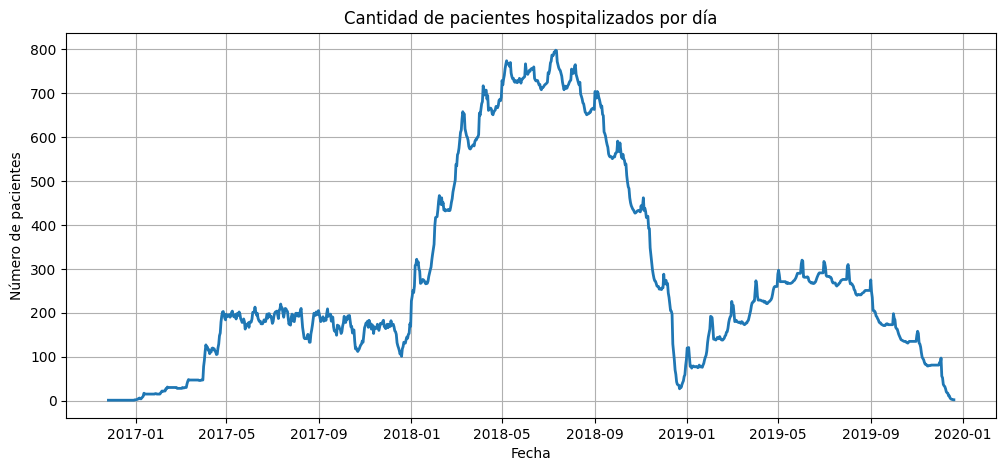

In [56]:

# Expandir el rango de fechas por paciente
df_expanded = (
    df_admission
    .apply(lambda row: pd.date_range(row['admission_date'], row['discharge_date'], freq='D'), axis=1)
    .explode()
    .to_frame(name='date')
)

# Agregar el ID del paciente
df_expanded['serial_number'] = df_admission.loc[df_expanded.index, 'serial_number'].values

# Agrupamos por fecha y contamos
daily_counts = (
    df_expanded
    .groupby('date')
    .size()
    .reset_index(name='num_patients')
)

# Graficamos la serie temporal
plt.figure(figsize=(12,5))
plt.plot(daily_counts['date'], daily_counts['num_patients'], linewidth=2)
plt.title('Cantidad de pacientes hospitalizados por día')
plt.xlabel('Fecha')
plt.ylabel('Número de pacientes')
plt.grid(True)
plt.show()


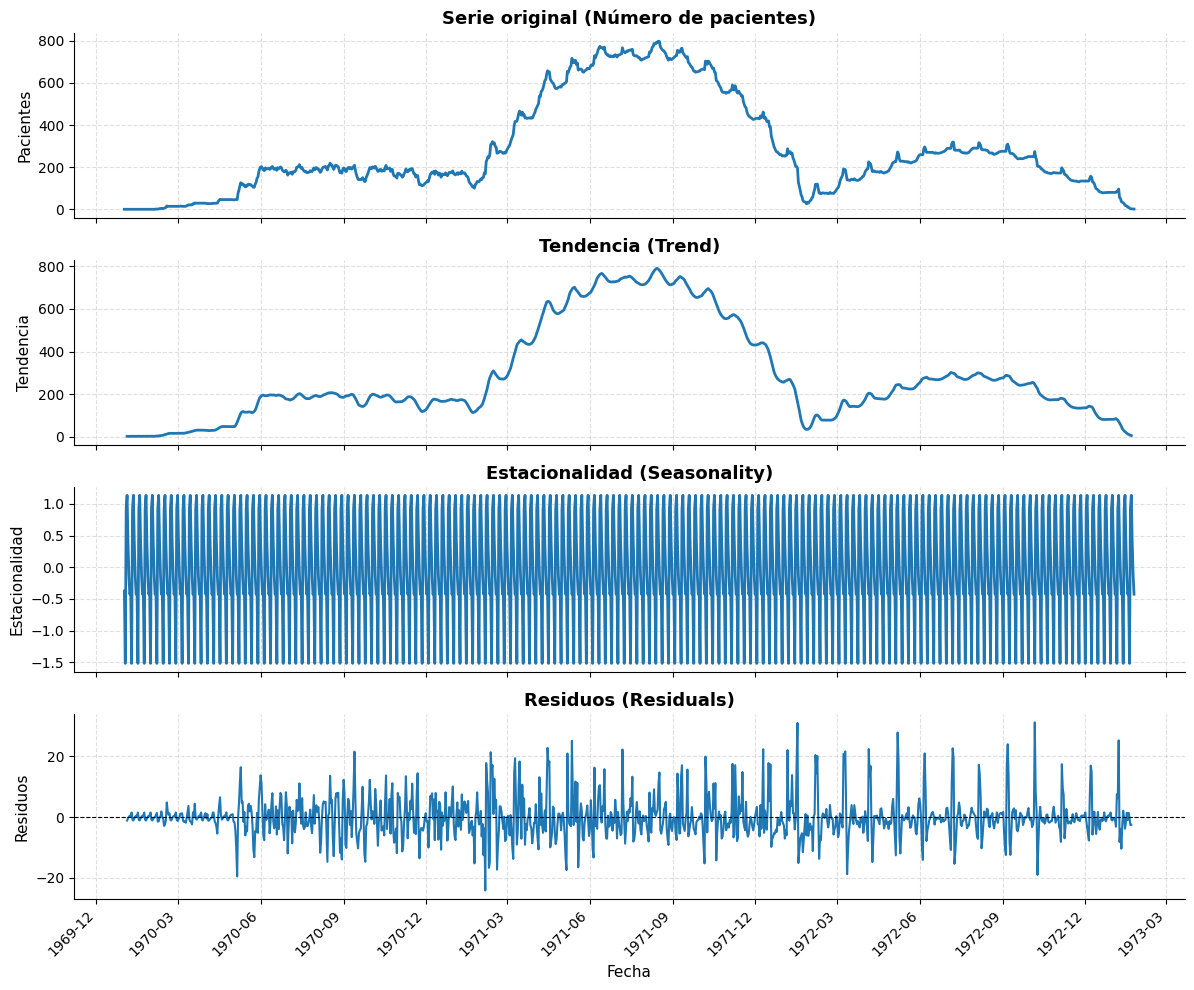

In [57]:

# Descomponer la serie
result = seasonal_decompose(
    daily_counts['num_patients'],
    model='additive',
    period=7
)


fig, axes = plt.subplots(4, 1, figsize=(12, 10), sharex=True)

# Serie original
axes[0].plot(result.observed, linewidth=2)
axes[0].set_title('Serie original (Número de pacientes)', fontsize=13, fontweight='bold')
axes[0].set_ylabel('Pacientes', fontsize=11)

# Tendencia
axes[1].plot(result.trend, linewidth=2)
axes[1].set_title('Tendencia (Trend)', fontsize=13, fontweight='bold')
axes[1].set_ylabel('Tendencia', fontsize=11)

# Estacionalidad
axes[2].plot(result.seasonal, linewidth=2)
axes[2].set_title('Estacionalidad (Seasonality)', fontsize=13, fontweight='bold')
axes[2].set_ylabel('Estacionalidad', fontsize=11)

# Residuos
axes[3].plot(result.resid, linewidth=1.5)
axes[3].axhline(0, color='black', linestyle='--', linewidth=0.8)
axes[3].set_title('Residuos (Residuals)', fontsize=13, fontweight='bold')
axes[3].set_ylabel('Residuos', fontsize=11)
axes[3].set_xlabel('Fecha', fontsize=11)

# --- Formatear eje X con fechas ---
axes[3].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
axes[3].xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # cada 3 meses
fig.autofmt_xdate(rotation=45)

# Ajustes estéticos
for ax in axes:
    ax.grid(True, linestyle='--', alpha=0.4)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)


plt.tight_layout()
plt.show()


/var/folders/20/xpqdbsrj4wb6tc710ddf8s880000gn/T/ipykernel_5421/167714925.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([data_male, data_female],


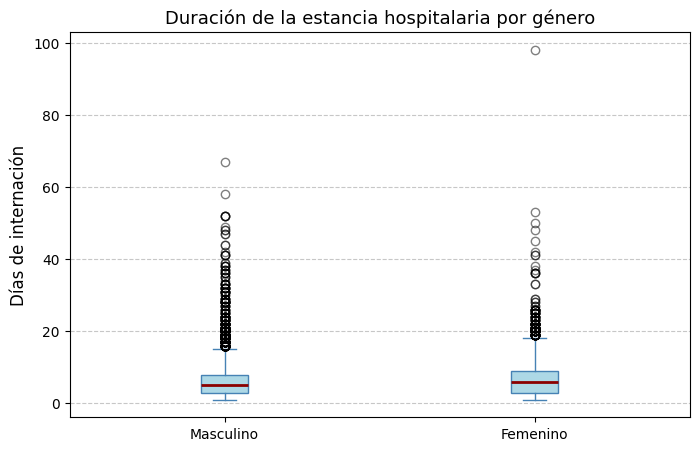

In [58]:

# Filtramos datos válidos (sin NaN en las dos columnas)
df_valid = df_admission.dropna(subset=['length_of_stay_days', 'gender'])

# Agrupamos los datos por género
data_male = df_valid.loc[df_valid['gender'] == 'M', 'length_of_stay_days']
data_female = df_valid.loc[df_valid['gender'] == 'F', 'length_of_stay_days']

# Creamos el boxplot
plt.figure(figsize=(8,5))
plt.boxplot([data_male, data_female],
            labels=['Masculino', 'Femenino'],
            patch_artist=True,
            boxprops=dict(facecolor='lightblue', color='steelblue'),
            medianprops=dict(color='darkred', linewidth=2),
            whiskerprops=dict(color='steelblue'),
            capprops=dict(color='steelblue'),
            flierprops=dict(marker='o', color='gray', alpha=0.5))

plt.title('Duración de la estancia hospitalaria por género', fontsize=13)
plt.ylabel('Días de internación', fontsize=12)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()


In [59]:
daily_counts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1120 entries, 0 to 1119
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          1120 non-null   datetime64[ns]
 1   num_patients  1120 non-null   int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 17.6 KB


## Modelos base

In [60]:
from statsforecast import StatsForecast
from statsforecast.models import Naive, HistoricAverage, WindowAverage, SeasonalNaive

In [61]:
# --- Ajustar formato del DataFrame ---
df = daily_counts.rename(columns={
    'date': 'ds',
    'num_patients': 'y'
})
df['unique_id'] = 'PACIENTES'

df.head()

,ds,y,unique_id
0,2016-11-26,1,PACIENTES
1,2016-11-27,1,PACIENTES
2,2016-11-28,1,PACIENTES
3,2016-11-29,1,PACIENTES
4,2016-11-30,1,PACIENTES


In [62]:
# Cantidad de dias que vamos a realizar nuestro pronostico
horizon = 7 

models = [
  Naive(), 
  HistoricAverage(), 
  WindowAverage(window_size=7), 
  SeasonalNaive(season_length=7)
]

sf = StatsForecast(models=models, freq="D") # frecuencia = daily
sf.fit(df=df)
preds = sf.predict(h=horizon)


In [63]:
preds.head()

,unique_id,ds,Naive,HistoricAverage,WindowAverage,SeasonalNaive
0,PACIENTES,2019-12-21,2.0,280.808929,4.428571,11.0
1,PACIENTES,2019-12-22,2.0,280.808929,4.428571,6.0
2,PACIENTES,2019-12-23,2.0,280.808929,4.428571,4.0
3,PACIENTES,2019-12-24,2.0,280.808929,4.428571,3.0
4,PACIENTES,2019-12-25,2.0,280.808929,4.428571,3.0


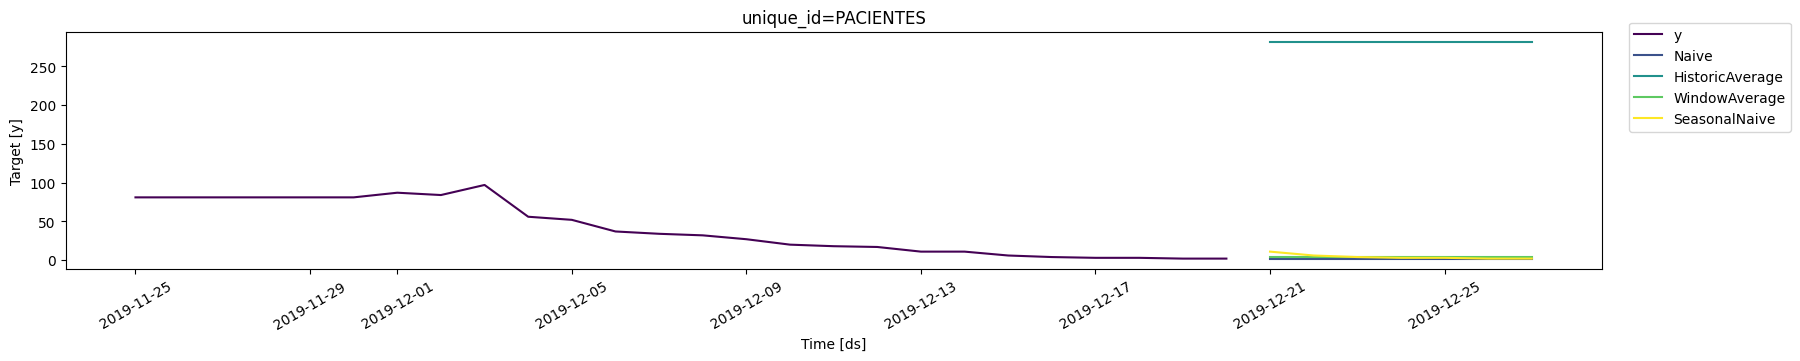

In [64]:
plot_series(
  df = df, 
  forecasts_df=preds, 
  ids=["PACIENTES"], 
  max_insample_length=26, 
  palette="viridis"
)